In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas  # used to load metadata table
import numpy as np
import sys
import lmfit as lmfit

import numpy as np
import os
from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm
import glob as glob

import jscatter as js
import pandas as pd
import pickle
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from matplotlib import rc
import h5py

import matplotlib.pyplot as plt
import midtools
midtools.__file__

from extra_geom import AGIPD_1MGeometry


In [2]:

def calculate_g2(ttc):
    """Calculate the g2 function from a TTC
    """
    g2 = []
    dg2 = []
    
    for i in range(1,ttc.shape[0]):
        g2.append(np.diag(ttc, k=i).mean())
        dg2.append(np.diag(ttc, k=i).std()/np.sqrt(len(np.diag(ttc, k=i))))
    return g2,dg2



def load_data(pathtodata,filenames, tmax):
    
    f=h5py.File(pathtodata+filenames[0], 'r')
    ttcs_raw=f['train_resolved/correlation/ttc'][:,:,:,:tmax,:tmax]
    #positions =f['train_resolved/sample_position/y'][:]
    #positionsz=f['train_resolved/sample_position/z'][:]
    #energy=f['pulse_resolved/xgm/energy'][:,:tmax]

    

    for filename in filenames[1:]:
        f=h5py.File(pathtodata+filename, 'r')
        ttcs_raw=np.append(ttcs_raw, f['train_resolved/correlation/ttc'][:,:,:,:tmax,:tmax], axis=0)
        #energy=np.append(energy,f['pulse_resolved/xgm/energy'][:,:tmax], axis=0)
        #positions =np.append(positions,f['train_resolved/sample_position/y'][:])
        #positionsz=np.append(positionsz,f['train_resolved/sample_position/z'][:])
        #average_intensity=np.append(average_intensity,f['average/image_2d'][:])

    qvalues=f['train_resolved/correlation/q'][:]
    
    return(ttcs_raw,qvalues)#positions,positionsz,energy,t_delay,




def load_saxs(pathtodata,run_numbers):
    "Function to load saxs, average 2d image, energy and sample position"
    files=[]
    for run in run_numbers:
        os.chdir(pathtodata)
        for file in glob.glob(f"r{run:04d}*.h5"):
            files.append(file)
    files=sorted(files)

            
    print(files)
    f=h5py.File(pathtodata+files[0], 'r')
    I=f['pulse_resolved/azimuthal_intensity/I'][:]
    q=f['pulse_resolved/azimuthal_intensity/q'][:]
    positions =f['train_resolved/sample_position/y'][:,1]
    positionsz=f['train_resolved/sample_position/y'][:,2]
    energy=f['pulse_resolved/xgm/energy'][:,:]
    average_intensity=f['average/intensity'][:]

    for filename in files[1:]:

        try:
            f=h5py.File(pathtodata+filename, 'r')
            I=np.append(I, f['pulse_resolved/azimuthal_intensity/I'][:], axis=0)
            energy=np.append(energy,f['pulse_resolved/xgm/energy'][:,:], axis=0)
            positions =np.append(positions,f['train_resolved/sample_position/y'][:,1])
            positionsz=np.append(positionsz,f['train_resolved/sample_position/y'][:,2])
            average_intensity=np.append(average_intensity,f['average/intensity'][:])
            print(f'loaded {filename}')
        except KeyError:
            print(f'ttc of {filename} not found')
        except FileNotFoundError:
            print(f'file {filename} not found')
        

    return(q,I,average_intensity,positions,positionsz,energy)#t_delay,


def correct_ttc(ttcs_raw,stride):
    
    ttcs=np.zeros([np.size(ttcs_raw,0),np.size(ttcs_raw,2),np.size(ttcs_raw,3),np.size(ttcs_raw,4)])
    
    for q in range(np.size(ttcs_raw,2)):
        for k in range(0,np.size(ttcs_raw,0)):
            ttcs[k,q,:,:]=(ttcs_raw[k,0,q,:,:])-(ttcs_raw[k,stride,q,:,:])+1
    return(ttcs)
  

def std_filter(a,indices):
    std=np.zeros(np.size(a,0))
    
    for i in range(np.size(a,0)):
        x = (a[i,:,:]*indices[i,:,:] - np.average(a[i,:,:]*indices[i,:,:]))**2.
        std[i] = np.sqrt(np.average(x))
    return std


def calculate_ave_ttc(ttcs,qvalue,filtered_data,std_threshold,ttcmaxvalue,ttcminvalue,):
    
    weights = (ttcs[:,qvalue,:,:]>ttcminvalue)&(ttcs[:,qvalue,:,:]<ttcmaxvalue)
    value_std = std_filter(ttcs[:,qvalue,:,:],weights)
    
    
    filtering_std = (value_std<std_threshold)
    
    filter_tot = filtered_data&filtering_std
    
    weights=(ttcs[filter_tot,qvalue,:,:]>ttcminvalue)&(ttcs[filter_tot,qvalue,:,:]<ttcmaxvalue)
    ave_ttc=np.average(ttcs[filter_tot,qvalue,:,:],weights=weights,axis=0)
    return(ave_ttc,sum(filter_tot))



def exp_fun(x, A, tau,beta,inter):
    res = A * np.exp(-2*(x / tau) ** beta)+inter
    return res

    

Define the geometry for 2d plot

In [3]:
quad_pos = [(-542.0, 659.9348718347028),
               (-608.0, -34.99167535454035),
               (534.0, -220.99051698250696),
               (588.0, 473.9907060887199)]  


geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=quad_pos)

maskfile ='/gpfs/exfel/u/scratch/MID/202202/p003094/shared/masks/mask_r0057_02.npy'
mask=np.load(maskfile)
np.shape(mask)

(16, 512, 128)

In [4]:
pathtodata='/gpfs/exfel/u/scratch/MID/202202/p003094/Anita/analyzed_runs_photonised_ADU8p9_SAXS/p003094/'
proposal = 3094
filenames=['r00-analysis_000.h5']#['r0077-analysis_000.h5']

q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[85])#positions,positionsz,energy,t_delay

['r0085-analysis_001.h5', 'r0085-analysis_002.h5']
loaded r0085-analysis_002.h5


# Plot pulse dependence

Some threshold to get rid of the weaker pulses

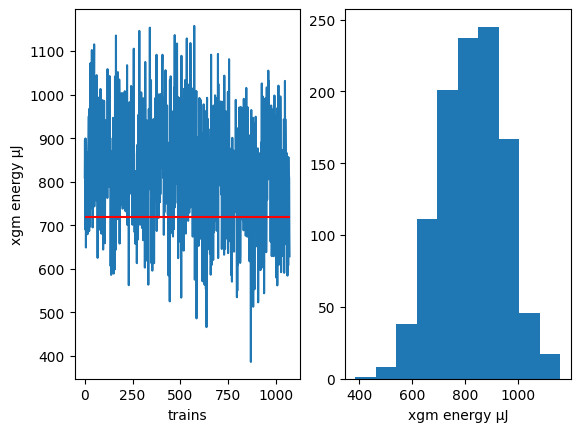

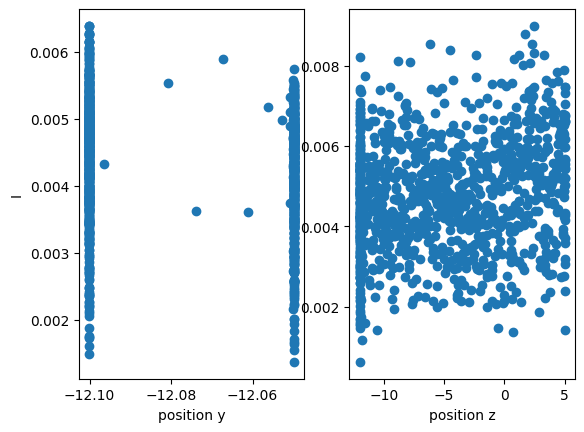

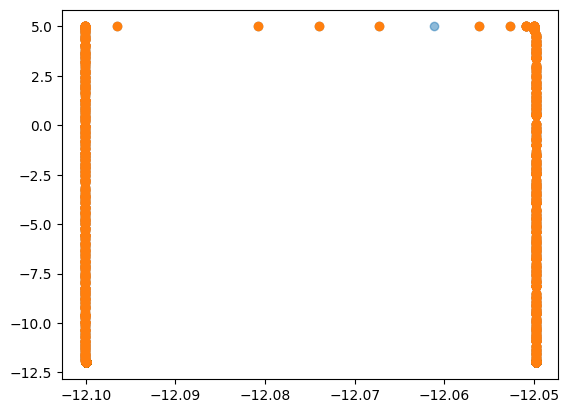

In [6]:
low_energy_threshold=720

mean_energy=energy[:,99]
plt.figure()
plt.subplot(1,2,1)
plt.plot(mean_energy)
plt.hlines(low_energy_threshold,0,len(mean_energy),color='red')

plt.xlabel('trains')
plt.ylabel('xgm energy μJ')

plt.subplot(1,2,2)

plt.hist(mean_energy)
plt.xlabel('xgm energy μJ')
plt.figure()
plt.subplot(1,2,1)
plt.plot(positions,np.mean(I[:,:,150],1),marker='o',ls='')

plt.xlabel('position y')
plt.ylabel('I')

plt.subplot(1,2,2)
plt.plot(positionsz,I[:,0,150],marker='o',ls='')

plt.xlabel('position z')


plt.figure()
plt.plot(positions,positionsz,marker='o',ls='',alpha=0.5)
plt.plot(positions[I[:,0,150]>0.0015],positionsz[I[:,0,150]>0.0015],marker='o',ls='')
good_trains=mean_energy>low_energy_threshold


The actual plots:

1- the whole range

2- around the low q where some changes are visible

(0.6, 1.05)

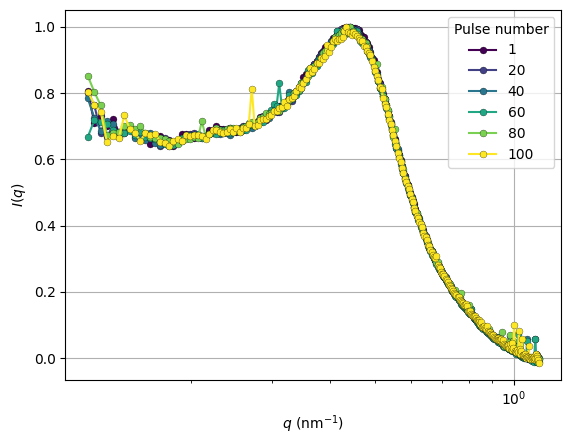

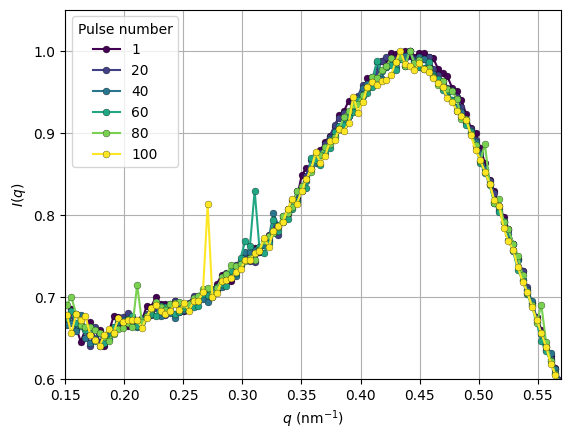

In [7]:
plt.figure()
tmax=np.size(I,1)
colore=plt.cm.viridis(np.linspace(0,1,tmax))

for i in [0,19,39,59,79,99]:
    i_norm=np.mean(I[good_trains,i,:],axis=0)-np.mean(I[good_trains,i,-10:],axis=(0,1))
    plt.plot(q,i_norm/max(i_norm[q>.3]),color=colore[i],label=f'{i+1}',marker='o',markeredgewidth=.2,markeredgecolor='black',markersize=5)

#plt.yscale('log')
plt.xscale('log')
plt.legend(title='Pulse number')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
#plt.xlim([0.19, 1.2])
plt.figure()
tmax=np.size(I,1)

for i in [0,19,39,59,79,99]:
    i_norm=np.mean(I[good_trains,i,:],axis=0)-np.mean(I[good_trains,i,-10:],axis=(0,1))
    plt.plot(q[:],i_norm[:]/max(i_norm[q>.3]),color=colore[i],label=f'{i+1}',marker='o',markeredgewidth=.2,markeredgecolor='black',markersize=5)

#plt.yscale('log')
#plt.xscale('log')
plt.legend(title='Pulse number')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0.15, 0.57])
plt.ylim([0.6, 1.05])


# Plot concentration dependence

Plot data without bkg subtraction or normalisation

['r0079-analysis_000.h5', 'r0079-analysis_001.h5']
loaded r0079-analysis_001.h5
800
['r0077-analysis_000.h5', 'r0077-analysis_001.h5']
loaded r0077-analysis_001.h5
796
['r0259-analysis_000.h5', 'r0259-analysis_001.h5']
loaded r0259-analysis_001.h5
494
['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
922


(0.0001, 0.1)

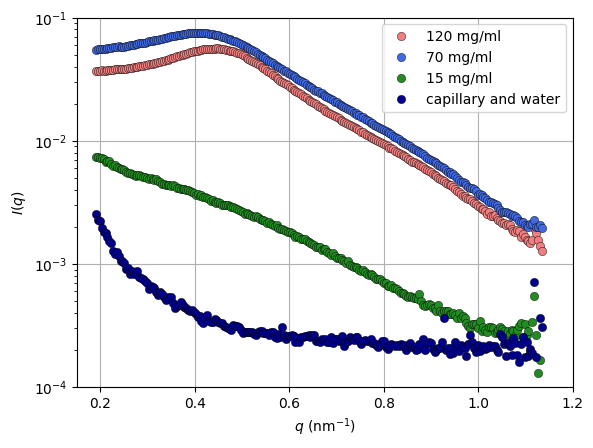

In [29]:
pathtodata='/gpfs/exfel/u/scratch/MID/202202/p003094/Anita/analyzed_runs_photonised_ADU8p9_SAXS/p003094/'

proposal = 3094
files=[79,77,259,146]

colore=['lightcoral','royalblue','forestgreen','darkblue']



low_energy_threshold=700

minpositionz=-12
maxpositionz=4.8

minposition=-.85
maxposition=.85

i=0

plt.figure()
for c,filenames in enumerate(files):
    
    
    
    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenames])#positions,positionsz,energy,t_delay
    
    filtering_energy=energy[:,i]>low_energy_threshold

    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)
    
    if c==3:
        filtering_positions=(positions<maxposition)&(positions>minposition)


    #filtering_mean=(value_mean>low_ttc_threshold)&(value_mean<high_ttc_threshold)
    
    good_trains=filtering_energy&filtering_positions
    
    print(sum(good_trains))
    i_norm=np.mean(I[good_trains,i,:],axis=0)
    if c==3:
            i_norm=np.mean(I[good_trains,i,:],axis=0)*2.7
    
    plt.plot(q[18:],i_norm[18:],color=colore[c],label=f'{i+1}',marker='o',ls='',   markeredgewidth=.3,markeredgecolor='black')
#plt.plot(q, .0065*np.exp(-(radius*q)**2),ls='--',   markeredgewidth=.3,color='red')
plt.yscale('log')
#plt.xscale('log')
plt.legend(['120 mg/ml','70 mg/ml','15 mg/ml','capillary and water'])
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0.15, 1.2])

plt.ylim([0.0001, .1])

Plot data with bkg correction 

['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
trains for water:
821
['r0079-analysis_000.h5', 'r0079-analysis_001.h5']
loaded r0079-analysis_001.h5
trains for measurement:
771
['r0077-analysis_000.h5', 'r0077-analysis_001.h5']
loaded r0077-analysis_001.h5
trains for measurement:
767
['r0189-analysis_001.h5', 'r0189-analysis_003.h5', 'r0189-analysis_004.h5']
loaded r0189-analysis_003.h5
loaded r0189-analysis_004.h5
trains for measurement:
1285
['r0259-analysis_000.h5', 'r0259-analysis_001.h5']
loaded r0259-analysis_001.h5
trains for measurement:
342


(9.1e-05, 0.09)

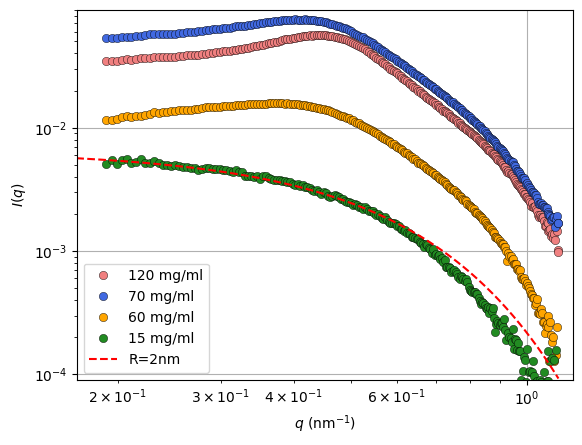

In [5]:
files=[79,77,189,259]
colore=['lightcoral','royalblue','orange','forestgreen']

low_energy_threshold=750

minpositionz=-12
maxpositionz=4.8

minposition=-.85
maxposition=.85
radius=1.97
i=0

q_water,I_water,average_intensity_water,positions,positionsz,energy=load_saxs(pathtodata,[146])#positions,positionsz,energy,t_delay
filtering_positions=(positions<maxposition)&(positions>minposition)
filtering_energy=energy[:,i]>low_energy_threshold
good_trains=filtering_energy&filtering_positions
print('trains for water:')
print(sum(good_trains))
I_water_ave=np.mean(I_water[good_trains,i,:],axis=0)*2.7

protein_concentration=[120,70,15]

plt.figure()
for c,filenumbers in enumerate(files):
    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenumbers])#positions,positionsz,energy,t_delay
    
    filtering_energy=energy[:,i]>low_energy_threshold
    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)

    good_trains=filtering_energy&filtering_positions
    print('trains for measurement:')
    print(sum(good_trains))

    i_norm=np.mean(I[good_trains,i,:],axis=0)-I_water_ave    
    plt.plot(q[18:],i_norm[18:],color=colore[c],label=f'{i+1}',marker='o',ls='',   markeredgewidth=.3,markeredgecolor='black')
plt.plot(q, .0065*np.exp(-(radius*q)**1.8),ls='--',   markeredgewidth=.3,color='red')

plt.yscale('log')
plt.xscale('log')
plt.legend(['120 mg/ml','70 mg/ml','60 mg/ml','15 mg/ml','R=2nm'])
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0.17, 1.2])
plt.ylim([0.000091, .09])

In [6]:
i_15=i_norm

(0.01, 2.0)

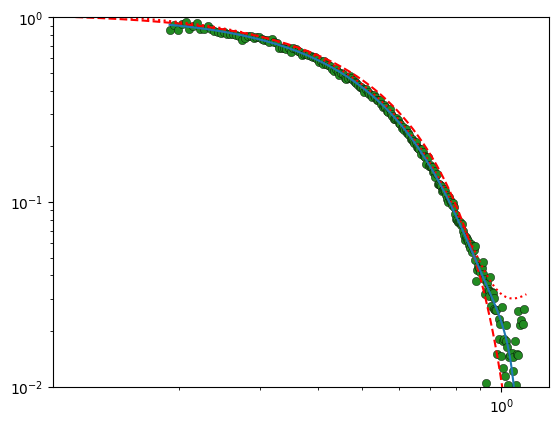

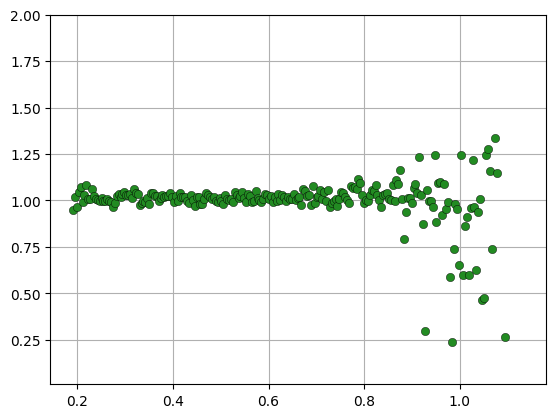

In [118]:

rad=3.8

FF_core=js.ff.sphereCoreShell(q, Rc=rad, Rs=4.4, bc=1, bs=0.174) 

FF=js.ff.sphere(q, radius=4.24,)



formf=FF.Y/FF.Y[0]+0.03

plt.figure()
plt.plot(q[18:],i_15[18:]/i_15[18]*.85,color=colore[c],label=f'{i+1}',marker='o',ls='',   markeredgewidth=.3,markeredgecolor='black')
plt.plot(FF_core.X,FF_core.Y/FF_core.Y[0],color='red',ls='--',   markeredgewidth=.3,markeredgecolor='black')

plt.plot(FF.X,formf,color='red',ls='dotted',   markeredgewidth=.3,markeredgecolor='black')

z = np.polyfit(q[18:],i_15[18:]/i_15[18]*.85, 4)
p15 = np.poly1d(z)

def ff15(q):
    return list(p15(q))

plt.plot(q[18:],ff15(q[18:]))


plt.yscale('log')
plt.xscale('log')

plt.ylim(.01,1)



plt.figure()
plt.plot(q[18:],i_15[18:]/ff15(q[18:])*1.7e2,color=colore[c],label=f'{i+1}',marker='o',ls='',   markeredgewidth=.3,markeredgecolor='black')


plt.grid('on')

plt.ylim(.01,2)


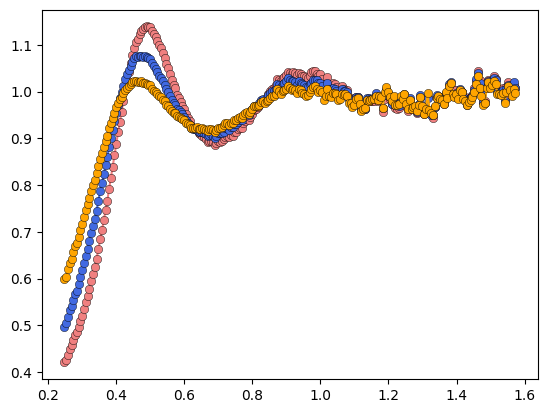

In [61]:
data = np.genfromtxt('//gpfs/exfel/u/scratch/MID/202202/p003094/Anita/SvQ-s2-70mgpml.dat',
                     dtype=None,
                     delimiter=' ')
q_sf=data[:,0]

S_70=data[:,3]
data = np.genfromtxt('//gpfs/exfel/u/scratch/MID/202202/p003094/Anita/SvQ-s10-60-70mgpml.dat',
                     dtype=None,
                     delimiter=' ')
S_60=data[:,3]
data = np.genfromtxt('//gpfs/exfel/u/scratch/MID/202202/p003094/Anita/SvQ-s6-120mgpml.dat',
                     dtype=None,
                     delimiter=' ')
S_120=data[:,3]


plt.plot(q_sf,S_120,color=colore[0],label=f'120',marker='o',   markeredgewidth=.3,markeredgecolor='black')
plt.plot(q_sf,S_70,color=colore[1],label=f'70',marker='o',   markeredgewidth=.3,markeredgecolor='black')
plt.plot(q_sf,S_60,color=colore[2],label=f'60',marker='o',   markeredgewidth=.3,markeredgecolor='black')

['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
trains for water:
821
['r0079-analysis_000.h5', 'r0079-analysis_001.h5']
loaded r0079-analysis_001.h5
trains for measurement:
771
['r0077-analysis_000.h5', 'r0077-analysis_001.h5']
loaded r0077-analysis_001.h5
trains for measurement:
767
['r0189-analysis_001.h5', 'r0189-analysis_003.h5', 'r0189-analysis_004.h5']
loaded r0189-analysis_003.h5
loaded r0189-analysis_004.h5
trains for measurement:
1285
['r0259-analysis_000.h5', 'r0259-analysis_001.h5']
loaded r0259-analysis_001.h5
trains for measurement:
342


(0.2, 1.5)

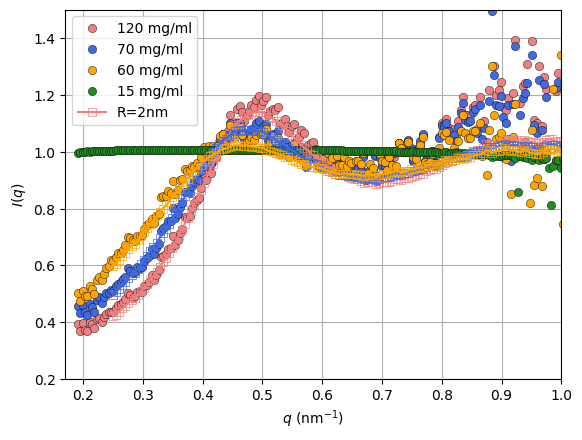

In [137]:
files=[79,77,189,259]
colore=['lightcoral','royalblue','orange','forestgreen']

low_energy_threshold=750

minpositionz=-12
maxpositionz=4.8

minposition=-.85
maxposition=.85
radius=2
i=0

q_water,I_water,average_intensity_water,positions,positionsz,energy=load_saxs(pathtodata,[146])#positions,positionsz,energy,t_delay
filtering_positions=(positions<maxposition)&(positions>minposition)
filtering_energy=energy[:,i]>low_energy_threshold
good_trains=filtering_energy&filtering_positions
print('trains for water:')
print(sum(good_trains))
I_water_ave=np.mean(I_water[good_trains,i,:],axis=0)*2.77

protein_concentration=[120,70,60,15]


FF_core=js.ff.sphereCoreShell(q, Rc=rad, Rs=6.2, bc=.4, bs=.095, solventSLD=.09)


plt.figure()
sq=np.zeros([len(q[18:]),len(protein_concentration)])
for c,filenumbers in enumerate(files[:]):
    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenumbers])#positions,positionsz,energy,t_delay
    
    filtering_energy=energy[:,i]>low_energy_threshold
    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)

    good_trains=filtering_energy&filtering_positions
    print('trains for measurement:')
    print(sum(good_trains))

    i_norm=(np.mean(I[good_trains,i,:],axis=0)-I_water_ave)/i_15[:]
    

    plt.plot(q[18:],i_norm[18:]/i_norm[-100],color=colore[c],label=f'{i+1}',marker='o',ls='',   markeredgewidth=.3,markeredgecolor='black')
#plt.plot(q, .0065*np.exp(-(radius*q)**2),ls='--',   markeredgewidth=.3,color='red')
#plt.plot(q, .0275*np.exp(-(radius*q)**2),ls='--',   markeredgewidth=.3,color='red')
#plt.plot(q, .1075*np.exp(-(radius*q)**2),ls='--',   markeredgewidth=.3,color='red')
#plt.plot(q, .1295*np.exp(-(radius*q)**2),ls='--',   markeredgewidth=.3,color='red')
    sq[:,c]=i_norm[18:]
plt.plot(q_sf,S_120,color=colore[0],label=f'120',marker='s',   markeredgewidth=.5,markerfacecolor='none')
plt.plot(q_sf,S_70,color=colore[1],label=f'70',marker='s',   markeredgewidth=.5,markerfacecolor='none')
plt.plot(q_sf,S_60,color=colore[2],label=f'60',marker='s',   markeredgewidth=.5,markerfacecolor='none')
#plt.yscale('log')
#plt.xscale('log')
plt.legend(['120 mg/ml','70 mg/ml','60 mg/ml','15 mg/ml','R=2nm'])
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0.17, 1])
plt.ylim([0.2, 1.5])

(0.2, 1.5)

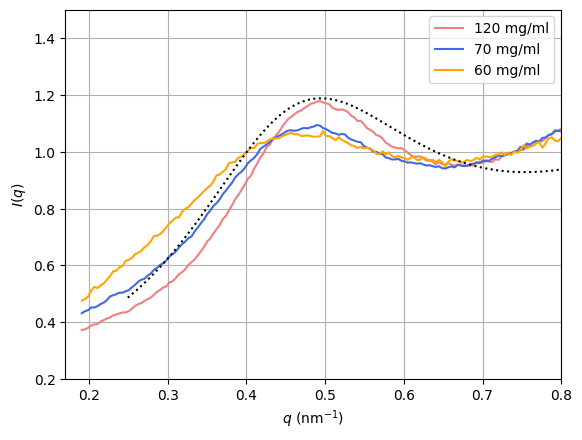

In [132]:
plt.figure()
for c in range(3):
    plt.plot(q[18:],sq[:,c],color=colore[c])
plt.legend(['120 mg/ml','70 mg/ml','60 mg/ml','15 mg/ml','R=2nm'])
c=2

Sq_js=js.sf.PercusYevick(q_sf, R=6.1, eta=.17)

plt.plot(np.transpose(Sq_js[0]),np.transpose(Sq_js[1]),color='black',linestyle='dotted')
Sq_js=js.sf.PercusYevick(q_sf, R=6.2, eta=.15)

#plt.plot(np.transpose(Sq_js[0]),np.transpose(Sq_js[1]),color='black',linestyle='dotted')
Sq_js=js.sf.PercusYevick(q_sf, R=6.2, eta=.11)
#plt.plot(np.transpose(Sq_js[0]),np.transpose(Sq_js[1]),color='black',linestyle='dotted')


#plt.plot(q_sf,S_120,color=colore[0],label=f'120',marker='s',   markeredgewidth=.5,markerfacecolor='none')
#plt.plot(q_sf,S_70,color=colore[1],label=f'70',marker='s',   markeredgewidth=.5,markerfacecolor='none')
#plt.plot(q_sf,S_60,color=colore[2],label=f'60',marker='s',   markeredgewidth=.5,markerfacecolor='none')
#

plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0.17, .8])
plt.ylim([0.2, 1.5])

## plot structure factor

['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
trains for water:
821
['r0259-analysis_000.h5', 'r0259-analysis_001.h5']
loaded r0259-analysis_001.h5
trains for water:
342
['r0079-analysis_000.h5', 'r0079-analysis_001.h5']
loaded r0079-analysis_001.h5
trains for measurement:
771
['r0077-analysis_000.h5', 'r0077-analysis_001.h5']
loaded r0077-analysis_001.h5
trains for measurement:
767
['r0189-analysis_001.h5', 'r0189-analysis_003.h5', 'r0189-analysis_004.h5']
loaded r0189-analysis_003.h5
loaded r0189-analysis_004.h5
trains for measurement:
1285


(0.14, 1.2)

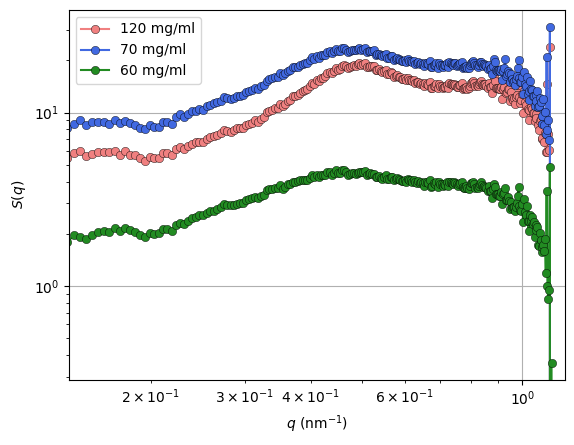

In [30]:
files=[79,77,189]
colore=['lightcoral','royalblue','forestgreen']

low_energy_threshold=750

minpositionz=-12
maxpositionz=4.8

minposition=-.85
maxposition=.85

i=0

q_water,I_water,average_intensity_water,positions,positionsz,energy=load_saxs(pathtodata,[146])#positions,positionsz,energy,t_delay
filtering_positions=(positions<maxposition)&(positions>minposition)
filtering_energy=energy[:,i]>low_energy_threshold
good_trains=filtering_energy&filtering_positions
print('trains for water:')
print(sum(good_trains))
I_water_ave=np.mean(I_water[good_trains,i,:],axis=0)


q_15,I_15,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[259])#positions,positionsz,energy,t_delay
filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)
filtering_energy=energy[:,i]>low_energy_threshold
good_trains=filtering_energy&filtering_positions
print('trains for water:')
print(sum(good_trains))
I_15_ave=np.mean(I_15[good_trains,i,:],axis=0)-I_water_ave



protein_concentration=[120,70,15]




plt.figure()
for c,filenumbers in enumerate(files):
    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenumbers])#positions,positionsz,energy,t_delay
    
    filtering_energy=energy[:,i]>low_energy_threshold
    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)

    good_trains=filtering_energy&filtering_positions
    print('trains for measurement:')
    print(sum(good_trains))

    i_norm=np.mean(I[good_trains,i,:],axis=0)-I_water_ave 

    plt.plot(q,i_norm/I_15_ave,color=colore[c],label=f'{i+1}',marker='o',   markeredgewidth=.3,markeredgecolor='black')

plt.yscale('log')
plt.xscale('log')
plt.legend(['120 mg/ml','70 mg/ml','60 mg/ml','water'])
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$S(q)$')
plt.grid('on')
plt.xlim([0.14, 1.2])


Check for the dilute sample (ferritin 15 mg/ml) in the guinier region if the radius of gyration is reasonable  

(0.00071, 0.0091)

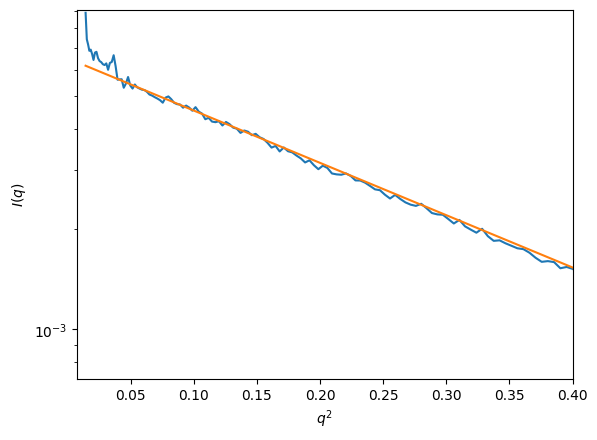

In [42]:
radius=1.9
plt.figure()
plt.plot(q**2, (i_norm))
plt.plot(q**2, .0065*np.exp(-(radius*q)**2),marker='o',ls='',   markeredgewidth=.3,markeredgecolor='black')
plt.yscale('log')
plt.xlabel('$q^2$')
plt.ylabel('$I(q)$')
plt.xlim([0.0071, 0.4])
plt.ylim([0.00071, 0.0091])


In [ ]:
radius=1.9
plt.figure()
plt.plot(q**2, (i_norm))
plt.plot(q**2, .0065*np.exp(-(radius*q)**2),  markeredgewidth=.3,markeredgecolor='black')
plt.yscale('log')
plt.xlabel('$q^2$')
plt.ylabel('$I(q)$')

plt.xlim([0.0071, 0.8])



# Plot  fluence dependence

['r0149-analysis_000.h5', 'r0149-analysis_001.h5', 'r0149-analysis_002.h5']
loaded r0149-analysis_001.h5
loaded r0149-analysis_002.h5
trains for water:
753
['r0097-analysis_000.h5', 'r0097-analysis_001.h5']
loaded r0097-analysis_001.h5
trains for measurement:
521
['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
trains for water:
800
['r0079-analysis_000.h5', 'r0079-analysis_001.h5']
loaded r0079-analysis_001.h5
trains for measurement:
738
['r0143-analysis_000.h5', 'r0143-analysis_002.h5', 'r0143-analysis_003.h5']
loaded r0143-analysis_002.h5
loaded r0143-analysis_003.h5
trains for water:
804
['r0081-analysis_001.h5', 'r0081-analysis_002.h5']
loaded r0081-analysis_002.h5
trains for measurement:
624
['r0140-analysis_000.h5', 'r0140-analysis_001.h5', 'r0140-analysis_002.h5']
loaded r0140-analysis_001.h5
loaded r0140-analysis_002.h5
trains for water:
825
['r0085-analysis_001.h5', 'r0085-analysis_002.h5']
l

Text(0.5, 1.0, 'Ferritin 120 mg/ml, Pulse=100')

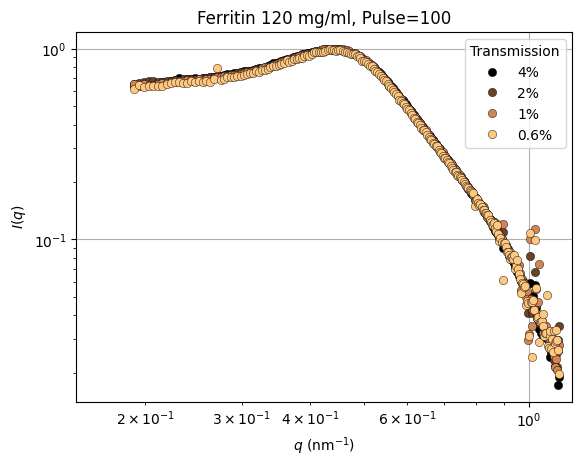

In [21]:

files=[97,79,81,85]
files_H2O=[[149],[146],[143],[140]]


colore=plt.cm.copper(np.linspace(0,1,len(files)))

multipling_factor=np.array([4,2,1,.6])/2
i=99


low_energy_threshold=720


plt.figure()
for c,filenumbers in enumerate(files):
    q_water,I_water,average_intensity_water,positions,positionsz,energy=load_saxs(pathtodata,files_H2O[c])#positions,positionsz,energy,t_delay
    filtering_positions=(positions<maxposition)&(positions>minposition)
    filtering_energy=energy[:,i]>low_energy_threshold
    good_trains=filtering_energy&filtering_positions
    print('trains for water:')
    print(sum(good_trains))
    I_water_ave=np.mean(I_water[good_trains,i,:],axis=0)


    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenumbers])#positions,positionsz,energy,t_delay
    

    filtering_energy=energy[:,i]>low_energy_threshold
    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)

    good_trains=filtering_energy&filtering_positions
    print('trains for measurement:')
    print(sum(good_trains))

    i_norm=np.mean(I[good_trains,i,:],axis=0)-I_water_ave 

    plt.plot(q[18:],i_norm[18:]/max(i_norm),color=colore[c],label=f'{i+1}',marker='o',ls='', markeredgewidth=.3,markeredgecolor='black')

plt.yscale('log')
plt.xscale('log')
plt.legend(['4%','2%','1%','0.6%'],title='Transmission')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0.15, 1.2])
plt.title(f'Ferritin 120 mg/ml, Pulse={i+1}')





['r0149-analysis_000.h5', 'r0149-analysis_001.h5', 'r0149-analysis_002.h5']
loaded r0149-analysis_001.h5
loaded r0149-analysis_002.h5
trains for water:
753
['r0097-analysis_000.h5', 'r0097-analysis_001.h5']
loaded r0097-analysis_001.h5
trains for measurement:
521
['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
trains for water:
800
['r0079-analysis_000.h5', 'r0079-analysis_001.h5']
loaded r0079-analysis_001.h5
trains for measurement:
738
['r0143-analysis_000.h5', 'r0143-analysis_002.h5', 'r0143-analysis_003.h5']
loaded r0143-analysis_002.h5
loaded r0143-analysis_003.h5
trains for water:
804
['r0081-analysis_001.h5', 'r0081-analysis_002.h5']
loaded r0081-analysis_002.h5
trains for measurement:
624
['r0140-analysis_000.h5', 'r0140-analysis_001.h5', 'r0140-analysis_002.h5']
loaded r0140-analysis_001.h5
loaded r0140-analysis_002.h5
trains for water:
825
['r0085-analysis_001.h5', 'r0085-analysis_002.h5']
l

Text(0.5, 1.0, 'Ferritin 120 mg/ml, Pulse=100')

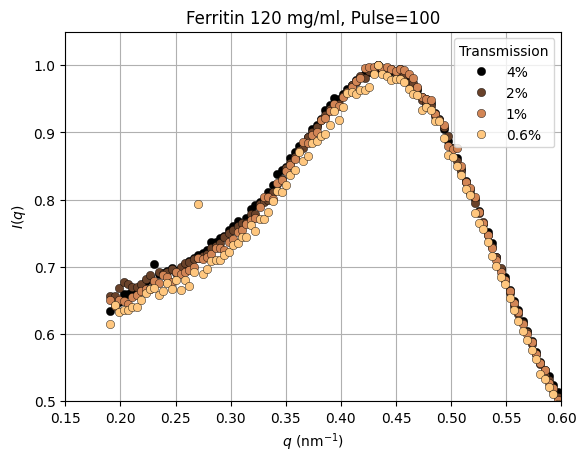

In [27]:

files=[97,79,81,85]
files_H2O=[[149],[146],[143],[140]]


colore=plt.cm.copper(np.linspace(0,1,len(files)))

multipling_factor=np.array([4,2,1,.6])/2
i=99


low_energy_threshold=720


plt.figure()
for c,filenumbers in enumerate(files):
    q_water,I_water,average_intensity_water,positions,positionsz,energy=load_saxs(pathtodata,files_H2O[c])#positions,positionsz,energy,t_delay
    filtering_positions=(positions<maxposition)&(positions>minposition)
    filtering_energy=energy[:,i]>low_energy_threshold
    good_trains=filtering_energy&filtering_positions
    print('trains for water:')
    print(sum(good_trains))
    I_water_ave=np.mean(I_water[good_trains,i,:],axis=0)


    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenumbers])#positions,positionsz,energy,t_delay
    

    filtering_energy=energy[:,i]>low_energy_threshold
    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)

    good_trains=filtering_energy&filtering_positions
    print('trains for measurement:')
    print(sum(good_trains))

    i_norm=np.mean(I[good_trains,i,:],axis=0)-I_water_ave 

    plt.plot(q[18:],i_norm[18:]/max(i_norm),color=colore[c],label=f'{i+1}',marker='o',ls='', markeredgewidth=.3,markeredgecolor='black')
    plt.xlim([.15, .6])
    plt.ylim([.5, 1.05])
    
#plt.yscale('log')
#plt.xscale('log')
plt.legend(['4%','2%','1%','0.6%'],title='Transmission')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.title(f'Ferritin 120 mg/ml, Pulse={i+1}')





['r0149-analysis_000.h5', 'r0149-analysis_001.h5', 'r0149-analysis_002.h5']
loaded r0149-analysis_001.h5
loaded r0149-analysis_002.h5
trains for water:
753
['r0097-analysis_000.h5', 'r0097-analysis_001.h5']
loaded r0097-analysis_001.h5
trains for measurement:
521
['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
trains for water:
800
['r0079-analysis_000.h5', 'r0079-analysis_001.h5']
loaded r0079-analysis_001.h5
trains for measurement:
738
['r0143-analysis_000.h5', 'r0143-analysis_002.h5', 'r0143-analysis_003.h5']
loaded r0143-analysis_002.h5
loaded r0143-analysis_003.h5
trains for water:
804
['r0081-analysis_001.h5', 'r0081-analysis_002.h5']
loaded r0081-analysis_002.h5
trains for measurement:
624
['r0140-analysis_000.h5', 'r0140-analysis_001.h5', 'r0140-analysis_002.h5']
loaded r0140-analysis_001.h5
loaded r0140-analysis_002.h5
trains for water:
825
['r0085-analysis_001.h5', 'r0085-analysis_002.h5']
l

Text(0.5, 1.0, 'Ferritin 120 mg/ml')

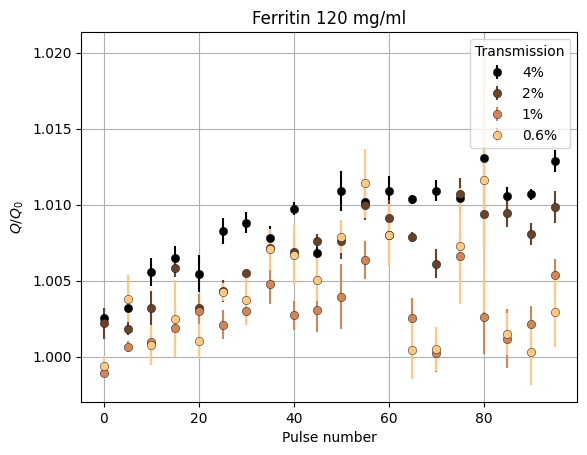

In [20]:
files=[97,79,81,85]
files_H2O=[[149],[146],[143],[140]]

colore=plt.cm.copper(np.linspace(0,1,len(files)))


qregion=(q>0.25)
qregionpeak=(q>0.45)&(q<.46)

pulses=np.arange(100)

def running_average(I,n_window):
    chunks=np.arange(0,len(pulses),n_window)
    Q=np.zeros(np.size(chunks))
    dQ=np.zeros(np.size(chunks))
    
    for n,i in enumerate(chunks):
        Q[n]=np.nanmean(I[i:i+5])
        dQ[n]=np.nanstd(I[i:i+5])/np.sqrt(n_window)
    return(Q,dQ)

files=[97,79,81,85]
files_H2O=[[149],[146],[143],[140]]


colore=plt.cm.copper(np.linspace(0,1,len(files)))

multipling_factor=np.array([4,2,1,.6])/2
i=99


low_energy_threshold=720


plt.figure()
for c,filenumbers in enumerate(files):

    q_water,I_water,average_intensity_water,positions,positionsz,energy=load_saxs(pathtodata,files_H2O[c])#positions,positionsz,energy,t_delay
    
    filtering_positions=(positions<maxposition)&(positions>minposition)
    filtering_energy=energy[:,i]>low_energy_threshold
    good_trains=filtering_energy&filtering_positions
    print('trains for water:')
    print(sum(good_trains))
    I_water_ave=np.mean(I_water[good_trains,:,:],axis=0)


    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenumbers])#positions,positionsz,energy,t_delay
    

    filtering_energy=energy[:,i]>low_energy_threshold
    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)

    good_trains=filtering_energy&filtering_positions

    print('trains for measurement:')
    print(sum(good_trains))

    I_filtered=np.mean(I[good_trains,:,:],0)
    i_bkg_corr=np.mean(I_filtered[:,qregion]*q[qregion]**2-I_water_ave[:,qregion]*q[qregion]**2,axis=(1))
    i_peak=np.mean(I_filtered[:,qregionpeak]*q[qregionpeak]**2-I_water_ave[:,qregionpeak]*q[qregionpeak]**2,axis=(1))
    

    I=i_bkg_corr/i_peak
    Q,dQ=running_average(I/I[0],5)

    plt.errorbar(pulses[::5],Q,dQ,color=colore[c],label=f'{i+1}',marker='o',ls='', markeredgewidth=.3,markeredgecolor='black')

#plt.yscale('log')
#plt.xscale('log')
plt.legend(['4%','2%','1%','0.6%'],title='Transmission')
plt.xlabel('Pulse number')
plt.ylabel('$Q/Q_0$')
plt.grid('on')
#plt.xlim([0.1, 1.2])
plt.title('Ferritin 120 mg/ml')





# Plot temperature dependence of ferritin 70 mg/ml

In [29]:
pathtodata='/gpfs/exfel/u/scratch/MID/202202/p003094/Anita/analyzed_runs_photonised_ADU8p9_SAXS/p003094/'
proposal = 3094
files=[77,131,189,201] 
colore=plt.cm.coolwarm(np.linspace(0,1,len(files)))

q_water,I_water,average_intensity_water,positions,positionsz,energy=load_saxs(pathtodata,[146])#positions,positionsz,energy,t_delay
filtering_positions=(positions<maxposition)&(positions>minposition)
filtering_energy=np.mean(energy[:,:],1)>low_energy_threshold
good_trains=filtering_energy&filtering_positions
print('trains for water:')
print(sum(good_trains))
I_water_ave=np.mean(I_water[good_trains,i,:],axis=0)



i=0
fig1=plt.figure()


for c,filenumbers in enumerate(files):
    
    q,I,average_intensity,positions,positionsz,energy=load_saxs(pathtodata,[filenumbers])#positions,positionsz,energy,t_delay
    

    filtering_energy=np.mean(energy[:,:],1)>low_energy_threshold
    filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)

    good_trains=filtering_energy&filtering_positions
    print('trains for measurement:')
    print(sum(good_trains))
  
    i_norm=np.mean(I[good_trains,i,:],axis=0)-I_water_ave    
    

    plt.plot(q,i_norm,color=colore[c],label=f'{i+1}',marker='o',ls='', markeredgewidth=.3,markeredgecolor='black')

#plt.yscale('log')



plt.xscale('log')
plt.legend(['21','21','0','-20'],title=r'Temperature ($^\circ$ C)')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0.1, 1.2])

['r0146-analysis_001.h5', 'r0146-analysis_002.h5', 'r0146-analysis_003.h5']
loaded r0146-analysis_002.h5
loaded r0146-analysis_003.h5
trains for water:
936
['r0077-analysis_000.h5', 'r0077-analysis_001.h5']
loaded r0077-analysis_001.h5
trains for measurement:
807
['r0131-analysis_000.h5', 'r0131-analysis_002.h5', 'r0131-analysis_003.h5']


# Change in the intensity pulse dependence

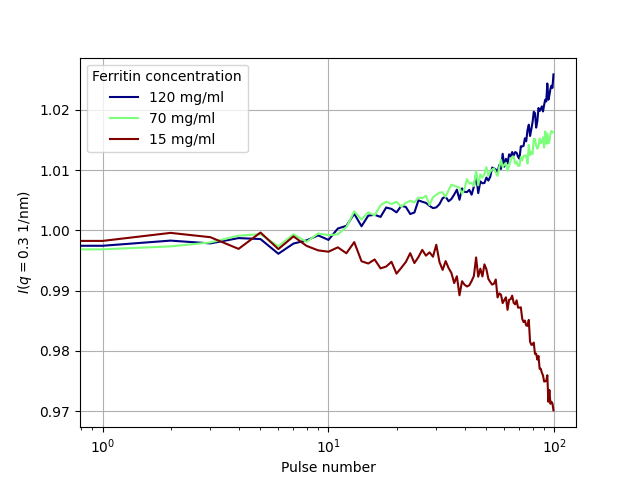

In [26]:
pathtodata='./analyzed_runs_masked/p003094/'
proposal = 3094
files=[['r0079-analysis_000.h5'],['r0077-analysis_000.h5'],['r0259-analysis_000.h5']]
colore=plt.cm.jet(np.linspace(0,1,len(files)))

q_water,I_water,average_intensity_water=load_saxs(pathtodata,['r0146-analysis_001.h5'])#positions,positionsz,energy,t_delay
qregions=[(q>0.2)&(q<.35)]
plt.figure()
for c,filenames in enumerate(files):
    q,I,average_intensity=load_saxs(pathtodata,filenames)#positions,positionsz,energy,t_delay
    i=0
    for qregion in qregions: 
        i_norm=np.mean(I[:,:,qregion],axis=(0,2))/np.mean(I[:,:,(q>0.4)&(q<0.5)],axis=(0,2))
        plt.plot(np.arange(np.size(I,1)),i_norm/i_norm[0],color=colore[c],label=f'{i+1}')

#plt.yscale('log')
plt.xscale('log')
plt.legend(['120 mg/ml','70 mg/ml','15 mg/ml','water'],title='Ferritin concentration')
plt.xlabel('Pulse number')
plt.ylabel(f'$I(q=${np.round(np.mean(q[qregions[0]]),1)} 1/nm)')
plt.grid('on')


(0.0, 1.2)

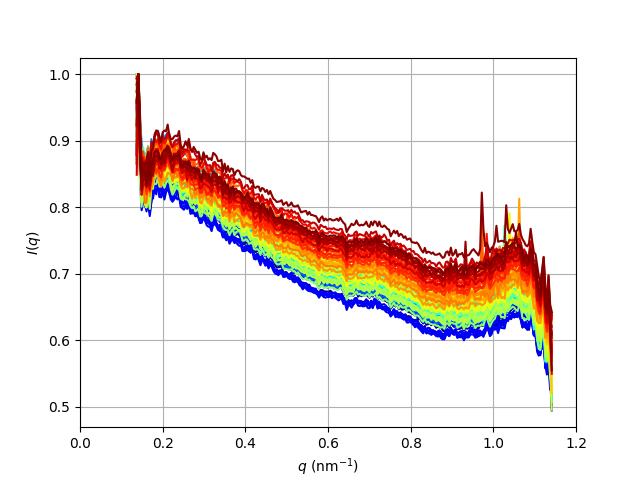

In [22]:
plt.figure()
tmax=np.size(I,1)
colore=plt.cm.jet(np.linspace(0,1,tmax))

for i in range(0,tmax):
    i_norm=np.mean(I[:,i,:],axis=0)
    plt.plot(q,i_norm/max(i_norm),color=colore[i])

#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([0, 1.2])

<IPython.core.display.Javascript object>


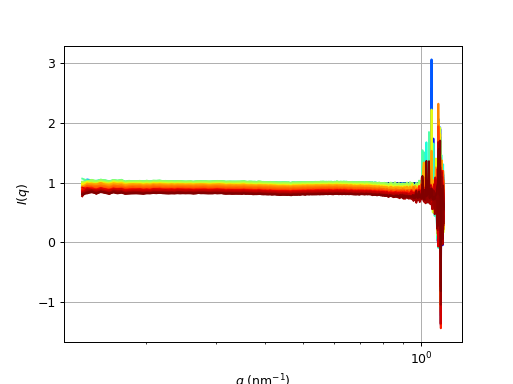

In [24]:
plt.figure()
tmax=np.size(I,1)
colore=plt.cm.jet(np.linspace(0,1,tmax))
i=0

i_norm0=np.mean(I[:,i,:],axis=0)-np.mean(I[:,i,-20:],axis=(0,1))


for i in range(0,tmax):
    i_norm=np.mean(I[:,i,:],axis=0)-np.mean(I[:,i,-20:],axis=(0,1))
    plt.plot(q,i_norm/i_norm0,color=colore[i])
plt.xscale('log')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')



In [103]:
plt.figure()
tmax=np.size(I,1)
colore=plt.cm.jet(np.linspace(0,1,tmax))

for i in range(0,tmax):
    i_norm=np.mean(I[:,i,:],axis=0)
    plt.plot(q,i_norm,color=colore[i])

#plt.yscale('log')
plt.xscale('log')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.grid('on')
plt.xlim([.08, 1.3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.08, 1.3)

<IPython.core.display.Javascript object>


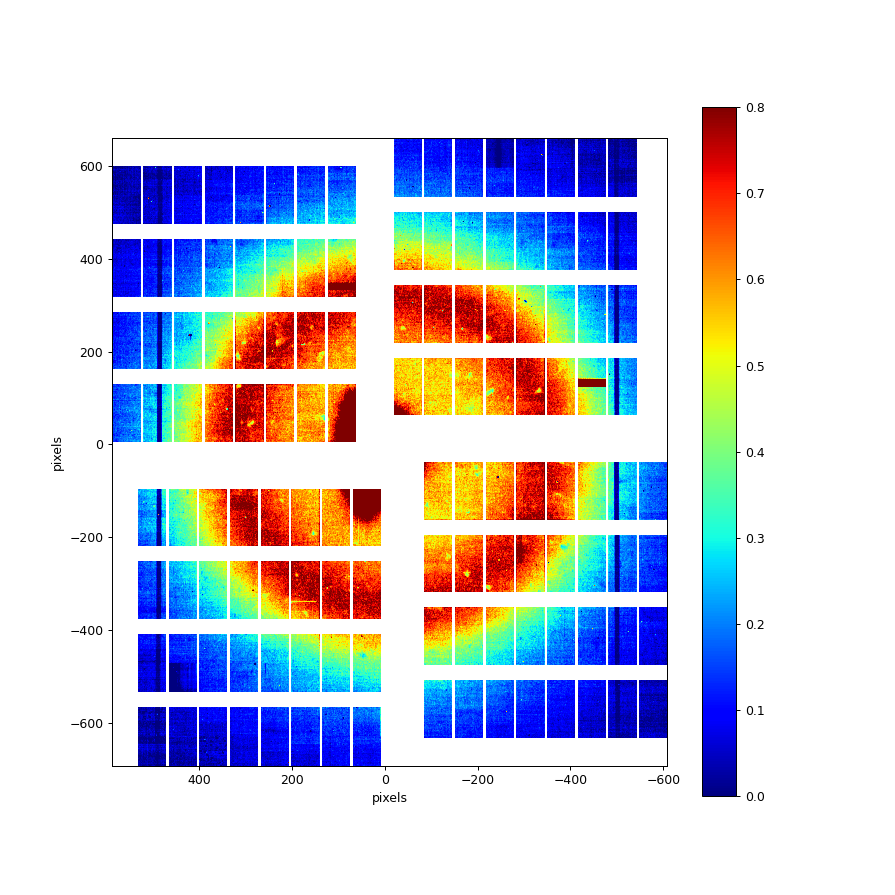

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [26]:
maskfile ='../shared/masks/mask_r0057_02.npy'
mask=np.load(maskfile)
np.shape(mask)

geom.plot_data_fast(np.mean(average_intensity[0,:,:,:,:],axis=0), figsize=(10,10),vmin=0,cmap='jet',vmax=.8)
#,norm=mpl.colors.LogNorm()

plt.colorbar()

In [139]:
mask = np.ones((16,8,64,128))

# Mask the edge pixels along the ASICS, these are twice as big
# as the other pixels so they'll affect the analysis.
mask[:,:,:2,:] = 0
mask[:,:,-2:,:] = 0
mask = mask.reshape((16,512,128))

# There are two vertical strips placed over the AGIPD to 
# block photons. These are only used for calibration so thay
# can be masked out.
mask[0,39:52] = 0
mask[1,38:51] = 0
mask[2,39:51] = 0
mask[3,38:50] = 0
mask[4,101:115] = 0
mask[5,99:112] = 0
mask[6,100:113] = 0
mask[7,99:112] = 0
mask[8,40:52] = 0
mask[9,39:52] = 0
mask[10,38:51] = 0
mask[11,36:50] = 0
mask[12,94:108] = 0
mask[13,93:108] = 0
mask[14,94:107] = 0
mask[15,93:107] = 0

# These are some regions on the detector that don't
# behave very well.
mask[0,4*64:5*64,:64] = 0
mask[3,1*64:2*64,48:64] = 0
mask[10,1*64:2*64,:64] = 0

mask = mask.astype('bool')


In [140]:
pixpos = geom.get_pixel_positions()
px, py, pz = np.moveaxis(pixpos, -1, 0)  # Separate x, y, z coordinates
angle = np.arctan2(py, px)
radius = np.sqrt(px**2 + py**2)
px.shape  # (modules, slow scan, fast scan)

(16, 512, 128)

In [164]:
rect_mask1 = ~(( px> 0) & (px < 0.02) & (-0.035 < py) & (py < 0))
rect_mask2 = ~( ( px> 0) & (px < 0.025) & (py<0.03) & (py > 0))
rect_mask3 = ~(( px> 0) & (px < 0.025) & (py<0.071) & (py > 0.066))
rect_mask4 = ~(( px> -0.015) & (px < 0.) & (py<0.02) & (py > 0))


triang_mask1 = ( py > 0)&( px > -.3*py+.025)&( py >0)|(px <0)|(py <0)
triang_mask2 = (( py > 0)&( px <2*py-.045))|( py <0)|( px >0)
triang_mask3 = ( py < 0)&( px < -1.3*py-.037)|( py >0)|(px >0)
triang_mask4 = (( py < 0)&( px >.8*py+.037))|( py >0)|( px <0)



rect_mask5 = ~(( px> -0.02) & (px < 0.) & (py<0) & (py > -0.015))
rect_mask6 = ~(( px> 0.043) & (px < 0.045) & (py<0.077) & (py > 0.06))
rect_mask7= ~(( px< -0.0575) & (px > -0.0595) & (py>-0.053) & (py < -0.035))
rect_mask8=~( px< -0.005)
#ring_mask = (0.02 < radius) & (radius < 0.021)
#wedge_mask = (np.pi * 1/2 < angle) & (angle < np.pi * 5.5/8) & (py<0.017) & (py > 0)

<IPython.core.display.Javascript object>


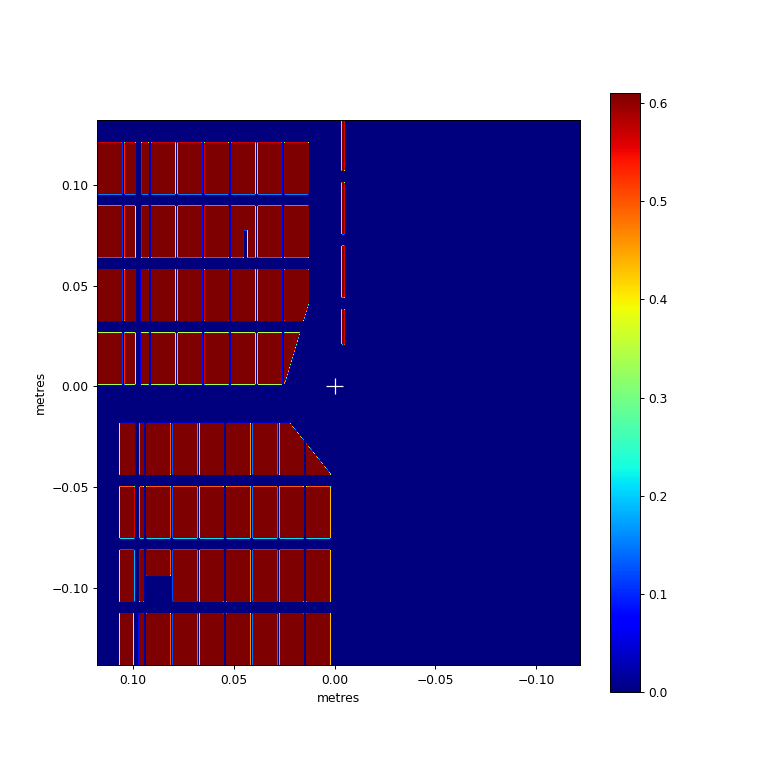

In [167]:
def visualise_mask(mask_arr):
    return geom.plot_data(
        # converting to float allows gaps to be distinguished as NaN.
    (mask_arr) ,axis_units="m", vmin=0., vmax=.61, figsize=(10, 10), origin='lower',cmap='jet',  
    )
#
maskfile ='../shared/masks/darkmask_r0032_00.npy'
mask=np.load(maskfile)
np.shape(mask)


mask2=(mask)*triang_mask1*triang_mask2*triang_mask3*triang_mask4*rect_mask5*rect_mask6*rect_mask7*rect_mask8
visualise_mask(np.array(mask2).astype("bool"))

np.save('../shared/masks/mask_1611_2.npy',mask2.astype('bool'))